### Loading the dataset

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from torchcam.methods import GradCAM
from torchvision.utils import make_grid
import random

In [24]:
def load_data(batch_size=32, trainval_split_ratio=0.8, data_root='./data'):
    trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    trainval_data = OxfordIIITPet(
        root=data_root,
        split='trainval',
        download=True,
        transform=trans
    )

    training_size = int(trainval_split_ratio * len(trainval_data))
    val_size = len(trainval_data) - training_size
    training_data, val_data = random_split(trainval_data, [training_size, val_size])

    training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    test_data = OxfordIIITPet(
        root=data_root,
        split='test',
        download=True,
        transform=trans
    )
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return training_loader, val_loader, test_loader, trainval_data

def plot_class_distribution(data_loader, dataset):
    class_counts = Counter([label for _, label in data_loader.dataset])
    class_to_index = dataset.class_to_idx
    index_to_class = {v: k for k, v in class_to_index.items()}

    distribution = {index_to_class[idx]: class_counts[idx] for idx in range(len(index_to_class))}
    sorted_distribution = dict(sorted(distribution.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 8))
    plt.barh(list(sorted_distribution.keys()), list(sorted_distribution.values()))
    plt.xlabel("Number of Images")
    plt.ylabel("Breed")
    plt.title("Class Distribution in Training Partition")
    plt.gca().invert_yaxis()
    plt.show()

In [25]:
training_loader, val_loader, test_loader, trainval_data = load_data()
training_size = int(0.8 * len(trainval_data))
val_size = len(trainval_data) - training_size

training_data, val_data = random_split(trainval_data, [training_size, val_size])

In [26]:
print(f"Number of training samples: {len(training_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 2944
Number of validation samples: 736


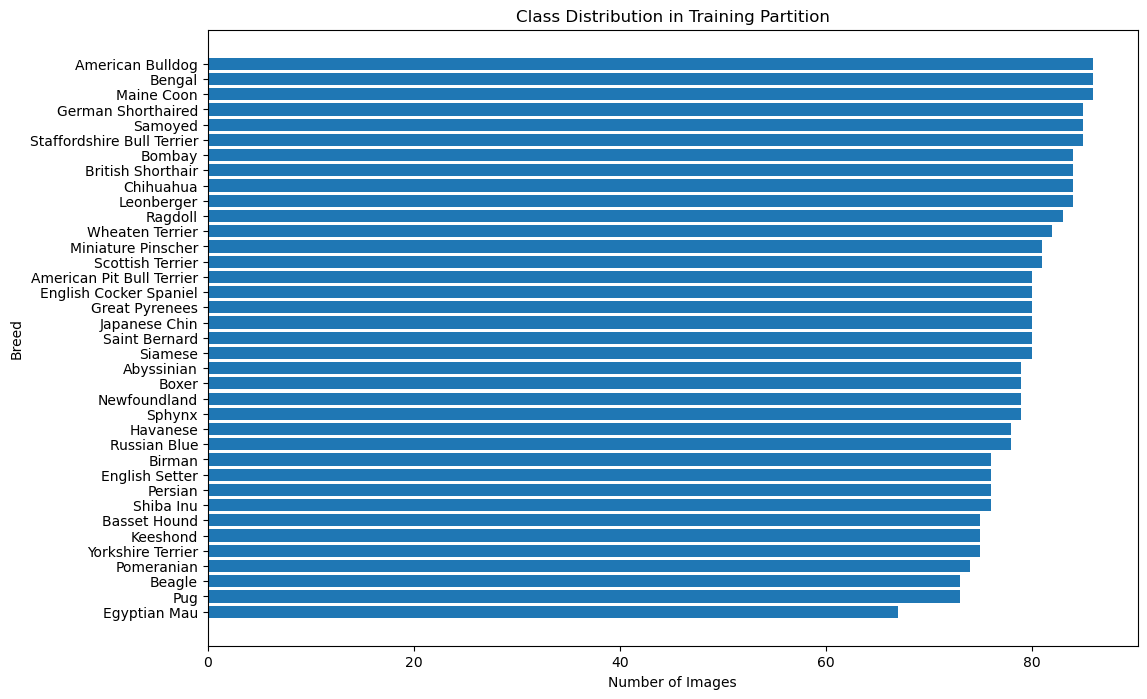

In [27]:
plot_class_distribution(training_loader, trainval_data)

In [28]:
resnet18 = models.resnet18(weights="IMAGENET1K_V1")
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
num_classes = 37

class ResNet18Modified(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Modified, self).__init__()
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.conv1 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv2 = nn.Conv2d(256, num_classes, kernel_size=1) 

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x.view(x.size(0), -1)

model = ResNet18Modified(num_classes=num_classes)
print(model)

ResNet18Modified(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [29]:
def train_and_validate_model(model, train_loader, val_loader, num_epochs=1, learning_rate=0.01, momentum=0.9):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs):
        model.train() 
        total_loss = 0.0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            predictions = model(batch_inputs)
            loss = loss_function(predictions, batch_labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_inputs.size(0)

        average_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

        model.eval()
        validation_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

                predictions = model(batch_inputs)
                loss = loss_function(predictions, batch_labels)
                validation_loss += loss.item() * batch_inputs.size(0)

                _, predicted_classes = torch.max(predictions, 1)
                total_samples += batch_labels.size(0)
                correct_predictions += (predicted_classes == batch_labels).sum().item()

        validation_loss /= len(val_loader.dataset)
        validation_accuracy = 100 * correct_predictions / total_samples
        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

In [31]:
def evaluate_model(model, test_data_loader, dataset, device):
    model.eval()

    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in test_data_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            
            output_logits = model(batch_inputs)
            _, predicted_classes = torch.max(output_logits, 1)
            
            actual_labels.extend(batch_labels.cpu().numpy())
            predicted_labels.extend(predicted_classes.cpu().numpy())

    actual_labels = np.array(actual_labels)
    predicted_labels = np.array(predicted_labels)

    accuracy = accuracy_score(actual_labels, predicted_labels)
    print(f"Accuracy on test partition: {accuracy:.4f}")

    f1_report = classification_report(actual_labels, predicted_labels, target_names=dataset.classes, output_dict=True)
    print("F1 Score (Macro):", f1_report['macro avg']['f1-score'])

    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [30]:
train_and_validate_model(model, training_loader, val_loader, num_epochs=1)

Epoch [1/1], Loss: 1.3453
Validation Loss: 0.9390, Validation Accuracy: 70.92%


Accuracy on test partition: 0.6923
F1 Score (Macro): 0.6871848205327847


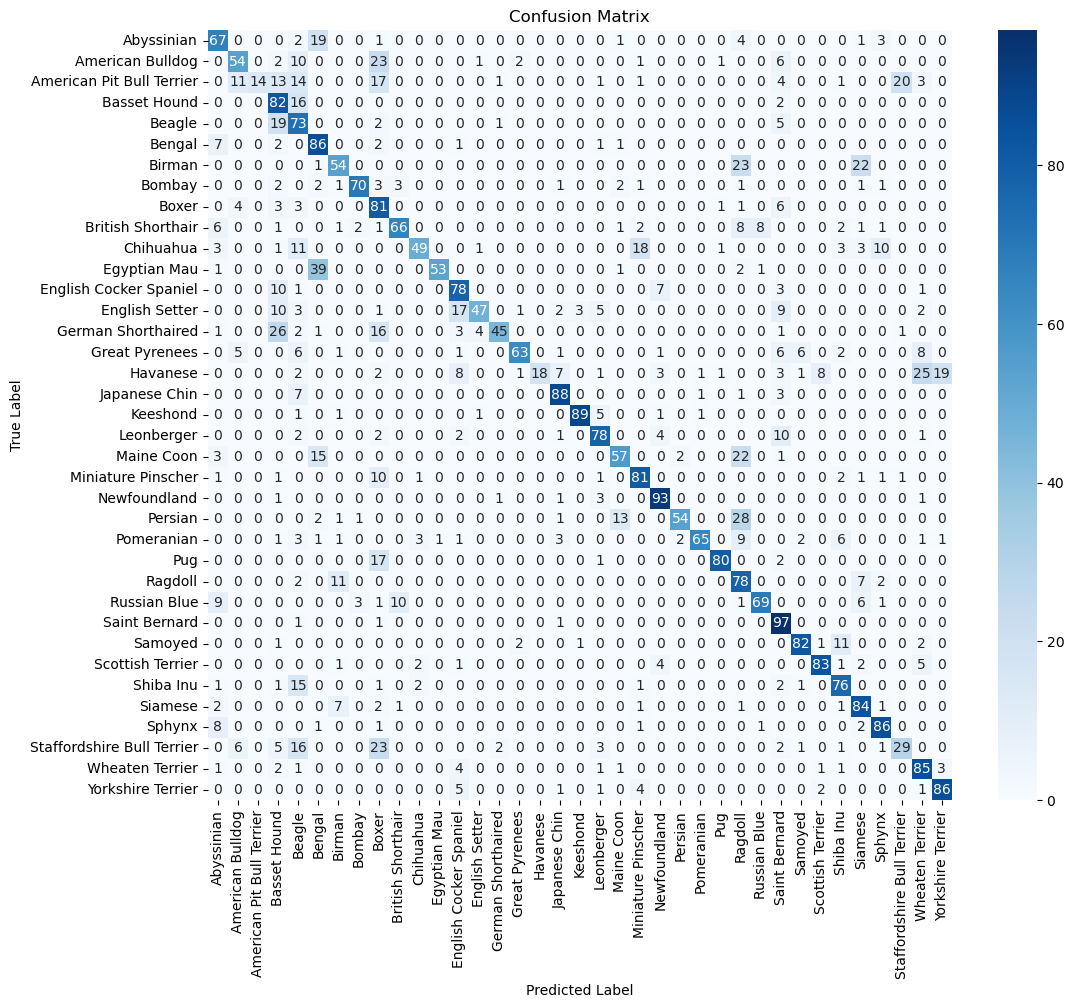

In [32]:
evaluate_model(model, test_loader, trainval_data, device)

In [33]:
def visualize_gradcam(images, cam_maps, labels, classes):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 5, i * 2 + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(f'True: {classes[labels[i]]}')

        plt.subplot(3, 5, i * 2 + 2)
        plt.imshow(cam_maps[i], cmap='jet', alpha=0.5)  # Overlay the CAM on the image
        plt.axis('off')
        plt.title(f'Pred: {classes[torch.argmax(cam_maps[i]).item()]}')

    plt.tight_layout()
    plt.show()